[QKSVM-ZZ] reps=2 α=1.0 γ=2.0 C=5.0 -> acc=0.970 f1=0.971
[LIN    ] C=1.0                        -> acc=0.430 f1=0.467
[RBF    ] C=1.0 γ=scale                -> acc=1.000 f1=1.000

Reporte QKSVM:
               precision    recall  f1-score   support

           0      1.000     0.940     0.969        50
           1      0.943     1.000     0.971        50

    accuracy                          0.970       100
   macro avg      0.972     0.970     0.970       100
weighted avg      0.972     0.970     0.970       100


Tabla de métricas:
        modelo  accuracy        f1
0    QKSVM-ZZ      0.97  0.970874
1  SVM-Linear      0.43  0.467290
2     SVM-RBF      1.00  1.000000


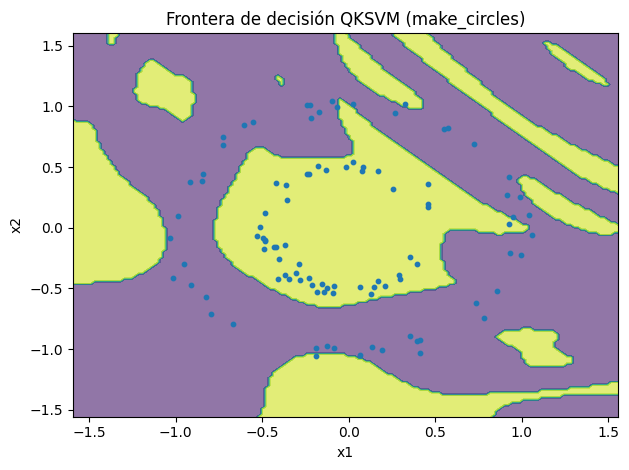

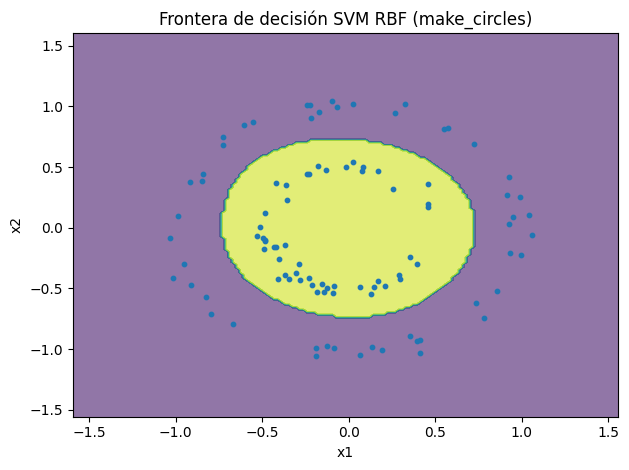

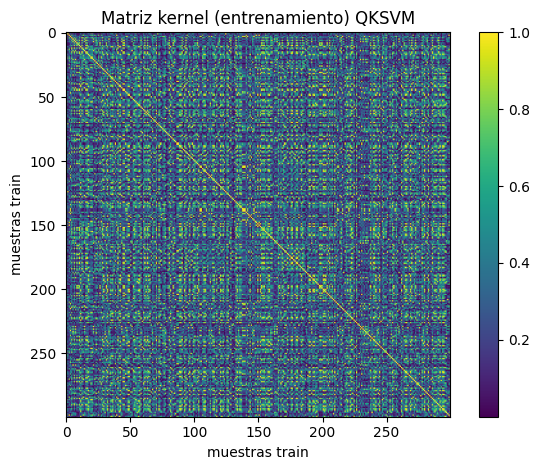

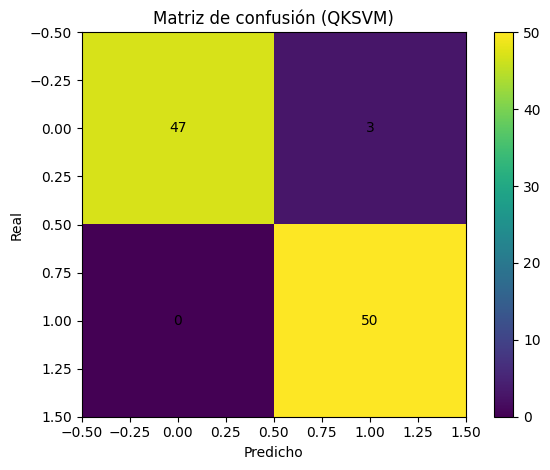

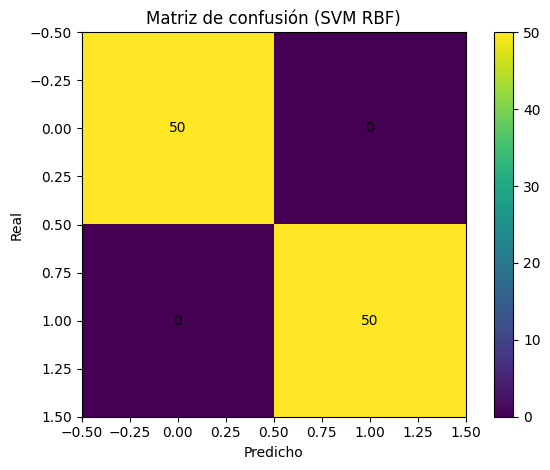

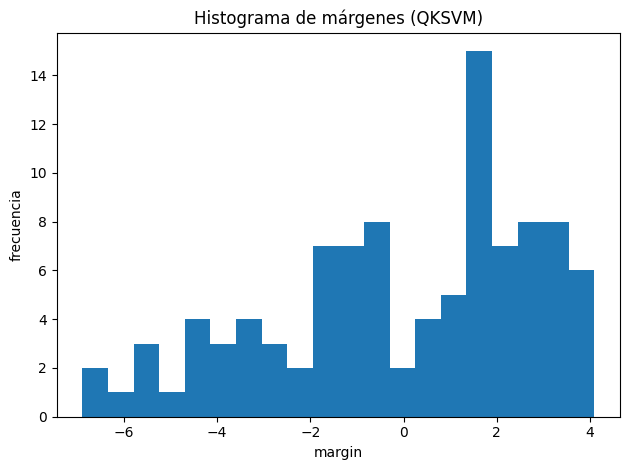

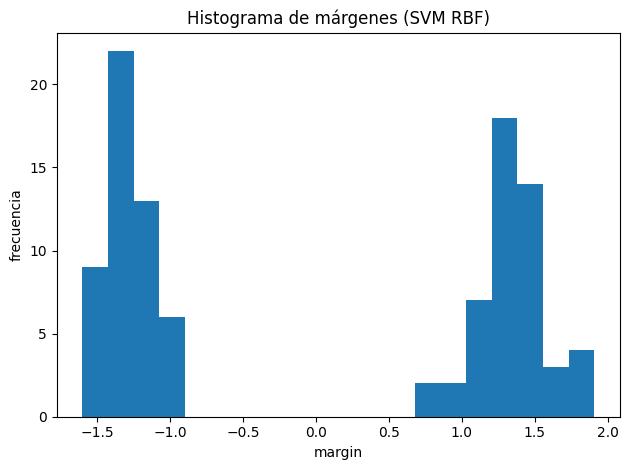

In [8]:
# QKSVM (make_circles) + gráficas complementarias
# Requisitos: pip install "qiskit>=2.0" scikit-learn numpy matplotlib

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import pandas as pd

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

# ============== 1) Datos ==============
X, y = make_circles(n_samples=400, factor=0.5, noise=0.05, random_state=0)

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=0
)

# Escalado para modelos clásicos
std = StandardScaler()
X_tr_std = std.fit_transform(X_tr)
X_te_std = std.transform(X_te)

# Escalado a ángulos [0, π] para embedding cuántico
ang = MinMaxScaler(feature_range=(0, np.pi))
X_tr_ang = ang.fit_transform(X_tr)
X_te_ang = ang.transform(X_te)

n_qubits = X_tr_ang.shape[1]  # 2

# ============== 2) Feature map tipo ZZ (simple y potente) ==============
def feature_circuit(x, reps=2, alpha=1.0, gamma=2.0):
    qc = QuantumCircuit(n_qubits)
    for _ in range(reps):
        for q in range(n_qubits):
            qc.h(q)
        for q in range(n_qubits):
            a = alpha * x[q]
            qc.rz(a, q)
            qc.ry(2*a, q)
        for i in range(n_qubits):
            for j in range(i+1, n_qubits):
                qc.rzz(gamma * x[i] * x[j], i, j)
    return qc

def embed_statevectors_array(Xa, reps=2, alpha=1.0, gamma=2.0):
    dim = 2**n_qubits
    S = np.empty((len(Xa), dim), dtype=complex)
    for i, x in enumerate(Xa):
        S[i, :] = Statevector.from_instruction(feature_circuit(x, reps, alpha, gamma)).data
    return S

def kernel_from_states(SA, SB):
    # K = |SA * SB^H|^2 (producto interno complejo al cuadrado)
    return np.abs(SA @ SB.conj().T) ** 2

# ============== 3) Entrenamiento QKSVM y baselines ==============
reps, alpha, gamma, C_q = 2, 1.0, 2.0, 5.0

S_tr = embed_statevectors_array(X_tr_ang, reps=reps, alpha=alpha, gamma=gamma)
S_te = embed_statevectors_array(X_te_ang, reps=reps, alpha=alpha, gamma=gamma)
K_tr = kernel_from_states(S_tr, S_tr)
K_te = kernel_from_states(S_te, S_tr)

qsvm = SVC(kernel='precomputed', C=C_q)
qsvm.fit(K_tr, y_tr)
y_pred_q = qsvm.predict(K_te)
acc_q = accuracy_score(y_te, y_pred_q)
f1_q  = f1_score(y_te, y_pred_q)

lin = SVC(kernel='linear', C=1.0)
lin.fit(X_tr_std, y_tr)
y_pred_lin = lin.predict(X_te_std)
acc_lin = accuracy_score(y_te, y_pred_lin)
f1_lin  = f1_score(y_te, y_pred_lin)

rbf = SVC(kernel='rbf', C=1.0, gamma='scale')
rbf.fit(X_tr_std, y_tr)
y_pred_rbf = rbf.predict(X_te_std)
acc_rbf = accuracy_score(y_te, y_pred_rbf)
f1_rbf  = f1_score(y_te, y_pred_rbf)

print(f"[QKSVM-ZZ] reps={reps} α={alpha} γ={gamma} C={C_q} -> acc={acc_q:.3f} f1={f1_q:.3f}")
print(f"[LIN    ] C=1.0                        -> acc={acc_lin:.3f} f1={f1_lin:.3f}")
print(f"[RBF    ] C=1.0 γ=scale                -> acc={acc_rbf:.3f} f1={f1_rbf:.3f}")
print("\nReporte QKSVM:\n", classification_report(y_te, y_pred_q, digits=3))

# Tabla de métricas
metrics_df = pd.DataFrame({
    "modelo": ["QKSVM-ZZ", "SVM-Linear", "SVM-RBF"],
    "accuracy": [acc_q, acc_lin, acc_rbf],
    "f1": [f1_q, f1_lin, f1_rbf]
})
try:
    from caas_jupyter_tools import display_dataframe_to_user
    display_dataframe_to_user("Resultados QKSVM vs baselines", metrics_df)
except Exception:
    print("\nTabla de métricas:\n", metrics_df)

# ============== 4) Gráficas (cada una en su figura) ==============

# (A) Frontera de decisión QKSVM (kernel precomputado)
x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 150),
    np.linspace(y_min, y_max, 150)
)
grid = np.c_[xx.ravel(), yy.ravel()]
grid_ang = ang.transform(grid)
S_grid = embed_statevectors_array(grid_ang, reps=reps, alpha=alpha, gamma=gamma)
K_grid = kernel_from_states(S_grid, S_tr)
Z_q = qsvm.predict(K_grid).reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, Z_q, alpha=0.6)
plt.scatter(X_te[:,0], X_te[:,1], s=10)
plt.title("Frontera de decisión QKSVM (make_circles)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.tight_layout()
plt.show()

# (B) Frontera de decisión SVM RBF
grid2_std = std.transform(grid)
Z_rbf = rbf.predict(grid2_std).reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, Z_rbf, alpha=0.6)
plt.scatter(X_te[:,0], X_te[:,1], s=10)
plt.title("Frontera de decisión SVM RBF (make_circles)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.tight_layout()
plt.show()

# (C) Mapa de calor del kernel de entrenamiento (QKSVM)
plt.figure()
plt.imshow(K_tr)
plt.title("Matriz kernel (entrenamiento) QKSVM")
plt.xlabel("muestras train")
plt.ylabel("muestras train")
plt.colorbar()
plt.tight_layout()
plt.show()

# (D) Matriz de confusión QKSVM
cm_q = confusion_matrix(y_te, y_pred_q)
plt.figure()
plt.imshow(cm_q)
for i in range(cm_q.shape[0]):
    for j in range(cm_q.shape[1]):
        plt.text(j, i, int(cm_q[i, j]), ha='center', va='center')
plt.title("Matriz de confusión (QKSVM)")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.colorbar()
plt.tight_layout()
plt.show()

# (E) Matriz de confusión RBF
cm_r = confusion_matrix(y_te, y_pred_rbf)
plt.figure()
plt.imshow(cm_r)
for i in range(cm_r.shape[0]):
    for j in range(cm_r.shape[1]):
        plt.text(j, i, int(cm_r[i, j]), ha='center', va='center')
plt.title("Matriz de confusión (SVM RBF)")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.colorbar()
plt.tight_layout()
plt.show()

# (F) Histogramas de márgenes (decision_function) para test
scores_q = qsvm.decision_function(K_te)
scores_r = rbf.decision_function(X_te_std)

plt.figure()
plt.hist(scores_q, bins=20)
plt.title("Histograma de márgenes (QKSVM)")
plt.xlabel("margin")
plt.ylabel("frecuencia")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(scores_r, bins=20)
plt.title("Histograma de márgenes (SVM RBF)")
plt.xlabel("margin")
plt.ylabel("frecuencia")
plt.tight_layout()
plt.show()

